In [1]:
# set to True if in colab
in_colab = True
floatType = 32
last_data_idx = -1

In [2]:
import tensorflow as tf
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
if floatType == 16:
    tf.keras.backend.set_floatx('float16')

Mounted at /content/drive


In [3]:
if in_colab:
    import sys
    data_dir = "/content/drive/MyDrive/data/"
    VOC2012_path = data_dir
    sys.path.append(data_dir)
    checkpoint_filepath = data_dir + "weights_unet_transfer_learning/"
else:
    data_dir = "../data/"
    VOC2012_path = data_dir + "VOCdevkit/"
    checkpoint_filepath = data_dir + "weights_unet_transfer_learning/"

## Import model

In [31]:
from models.UNET import UNET
input_shape=(128, 128, 3)
model = UNET(input_shape=input_shape, floatType = floatType, n_classes=3)

## Prepare VOC2012 segmentation data

  1%|          | 20/2912 [00:00<00:14, 196.69it/s]


Loading images and annotations...


100%|██████████| 2912/2912 [00:12<00:00, 228.88it/s]



Convert to tensor...


  5%|▍         | 50/1084 [00:00<00:02, 498.74it/s]


Done
Images shape: (1084, 128, 128, 3), annotations shape: (1084, 128, 128, 1)
Reshape gt from (width,height,1) to (width,height,n_classes)


100%|██████████| 1084/1084 [00:01<00:00, 667.84it/s]


Images shape: (1084, 128, 128, 3), annotations shape: (1084, 128, 128, 3)
Examples:


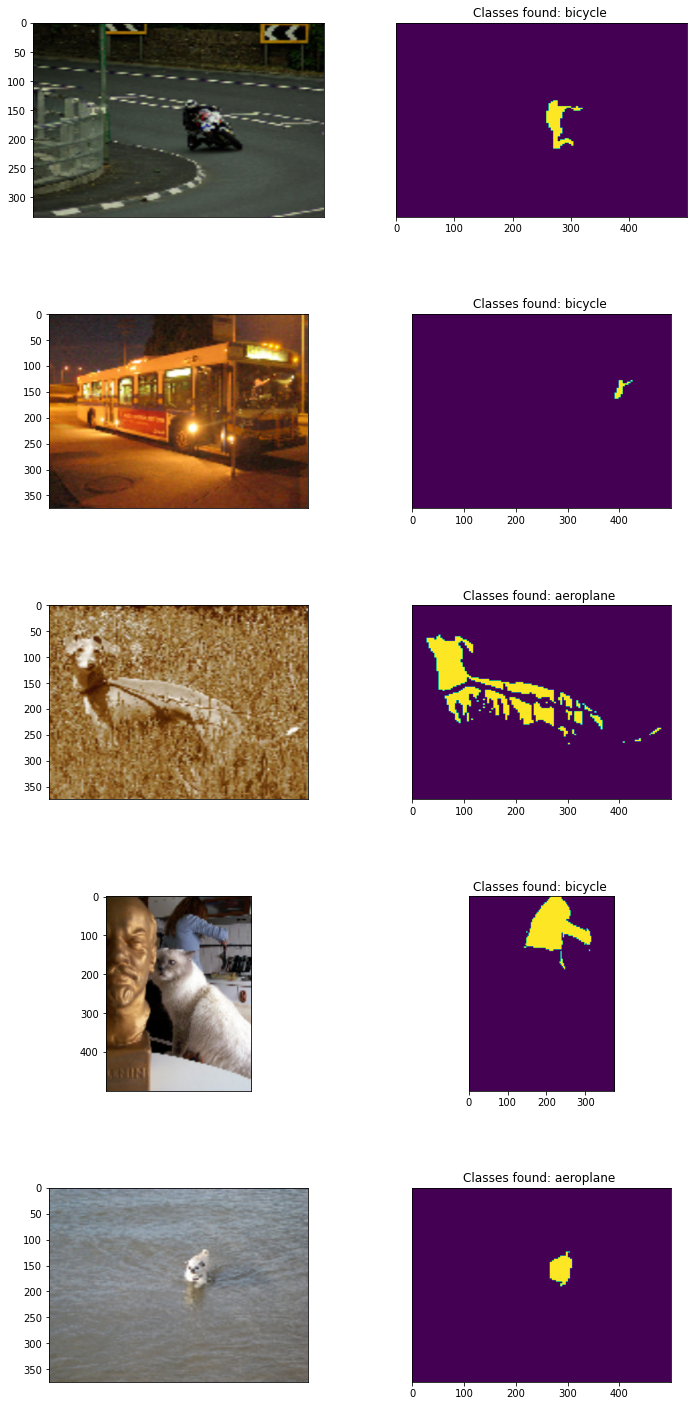

In [32]:
from data_management.VOC2012Manager import VOC2012Manager

manager = VOC2012Manager(floatType = floatType, input_shape=input_shape)
targets = ["person", "dog"]
images, gt_annotations, filenames_png, original_shapes =\
    manager.load_and_prepare_data(
        VOC2012_path=VOC2012_path,
        n_samples_to_show=5,
        targets=targets,
        last_data_idx=last_data_idx)

In [33]:
train_ratio = 0.7
batch_size = 32
train_dataset, val_dataset = manager.tensorf2TFData(images, gt_annotations, train_ratio, batch_size)

In [34]:
# verify train val shapes
for train_img, train_annot in train_dataset:
    break
for val_img, val_annot in val_dataset:
    break
print(f"Train images shape: {train_img.shape}, train annotations shape: {train_annot.shape}")
print(f"Val images shape: {val_img.shape}, Val annotations shape: {val_annot.shape}")
del train_img, train_annot, val_img, val_annot

Train images shape: (32, 128, 128, 3), train annotations shape: (32, 128, 128, 3)
Val images shape: (32, 128, 128, 3), Val annotations shape: (32, 128, 128, 3)


## Train model

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [36]:
# number of training images
train_count = images.shape[0] * train_ratio

# number of validation images
validation_count = images.shape[0] * (1 - train_ratio)

epochs = 100

steps_per_epoch = train_count//batch_size
validation_steps = validation_count//batch_size

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [37]:
history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset, validation_steps=validation_steps,
                    epochs=epochs, callbacks=[model_checkpoint_callback])

Epoch 1/100
23/23 [==============================] - 13s 513ms/step - loss: 0.9795 - accuracy: 0.7329 - val_loss: 0.5892 - val_accuracy: 0.8311
Epoch 2/100
23/23 [==============================] - 12s 509ms/step - loss: 0.6159 - accuracy: 0.8219 - val_loss: 0.5460 - val_accuracy: 0.8323
Epoch 3/100
23/23 [==============================] - 12s 510ms/step - loss: 0.5584 - accuracy: 0.8230 - val_loss: 0.5467 - val_accuracy: 0.8300
Epoch 4/100
23/23 [==============================] - 12s 512ms/step - loss: 0.6001 - accuracy: 0.8059 - val_loss: 0.5117 - val_accuracy: 0.8270
Epoch 5/100
23/23 [==============================] - 12s 515ms/step - loss: 0.5322 - accuracy: 0.8258 - val_loss: 0.5485 - val_accuracy: 0.8246
Epoch 6/100
23/23 [==============================] - 12s 515ms/step - loss: 0.5492 - accuracy: 0.8174 - val_loss: 0.5358 - val_accuracy: 0.8232
Epoch 7/100
23/23 [==============================] - 12s 510ms/step - loss: 0.5004 - accuracy: 0.8336 - val_loss: 0.5135 - val_accuracy:

In [21]:
model.load_weights(checkpoint_filepath)

In [22]:
model.save(data_dir + "unet_final_weights/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/unet_final_weights/assets
